In [1]:
## Generally setup
import numpy as np
import os
import os.path as op
import matplotlib.pyplot as plt
from langouEEG import *
from scipy.stats import *
from eeg_microstates3 import *
import pandas as pd
import time
import mne
import pickle
from mne.datasets import sample
from mne.datasets import fetch_fsaverage
from mpl_toolkits.mplot3d import Axes3D  # noqa
from langouMicrostates import *
from IPython.display import clear_output as clear
import logging
# import easyEEG

sample_data_folder = mne.datasets.sample.data_path()
dataRoot = "/data/home/viscent/Light"
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
isMale = False
isAll = True
isBlind = False
if not isAll:
    result_dir = op.join(dataRoot,'result','male' if isMale else 'female')
else:
    result_dir = op.join(dataRoot,'result','all')
if isBlind:
    result_dir = op.join(result_dir,'Blind')
subjects_dir = op.dirname(fs_dir)
if not op.exists(result_dir):
    os.mkdir(result_dir)
# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
print(__doc__)

0 files missing from root.txt in /data/home/viscent/freesurfer/subjects
0 files missing from bem.txt in /data/home/viscent/freesurfer/subjects/fsaverage
Automatically created module for IPython interactive environment


In [2]:
## Input EEG data and extarct epochs

epochs_4F = dict()
epochs_RF = dict()
epochs_4R = dict()
epochs_RR = dict()

tmin_rest, tmax_rest, tmin_flick,tmax_flick = 40, 60, 15, 30
tmin_R_flick, tmax_R_flick = 20, 25

for subject_name in range(1,21):
    
    if not isAll:
        if not (isMale ^ (subject_name in [7,8,11,17])):
            continue
    if subject_name<10:
        subject_name='S0'+str(subject_name)
    else:
        subject_name='S'+str(subject_name)
    with open(dataRoot+'/clean_data_av/'+subject_name+'_clean.lgeeg','rb') as f:
        raw=pickle.load(f)
    events, event_dict=extractEvents(raw)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                        exclude='bads')
    if isBlind:
        epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochsBlind(raw,events,picks, 
        tmin_rest = 60,tmax_rest = 87,tmin_flick = 3,tmax_flick = 30)
    else:
        epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs_id(raw,events,picks, 
        tmin_rest = tmin_rest,tmax_rest = tmax_rest,tmin_flick = tmin_flick,tmax_flick = tmax_flick)
        _,epoch_RF,_,_ = extractEpochs_id(raw,events,picks, 
        tmin_rest = tmin_rest,tmax_rest = tmax_rest,tmin_flick = tmin_R_flick,tmax_flick = tmax_R_flick)
    epochs_4F[subject_name]=epoch_4F
    epochs_RF[subject_name]=epoch_RF
    epochs_RR[subject_name]=epoch_RR
    epochs_4R[subject_name]=epoch_4R
    if not op.exists(os.path.join(dataRoot,'fwd_solution.lgeeg')):
        fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                        bem=bem, eeg=True, mindist=5.0, n_jobs=1)
        print(fwd)
        mne.write_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'),fwd,overwrite=True)
    else:
        fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))
    data_path = sample.data_path()

    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                        exclude='bads')
    # Clear output display
    clear()

## Concact epochs
epoch_4F = mne.concatenate_epochs(list(epochs_4F.values()))
epoch_RF = mne.concatenate_epochs(list(epochs_RF.values()))
epoch_4R = mne.concatenate_epochs(list(epochs_4R.values()))
mne.epochs.equalize_epoch_counts([epoch_4F, epoch_RF, epoch_RR])

# Clear output display
clear()

In [3]:
result_dir = "/data/home/viscent/Light/result/microstates"
tm = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
time_augs=[['min_rest','max_rest','min_flick','max_flick','min_random_flick','max_random_flick']
,[tmin_rest, tmax_rest, tmin_flick, tmax_flick, tmin_R_flick, tmax_R_flick]]
to_save_cache = True

(1050105, 64)


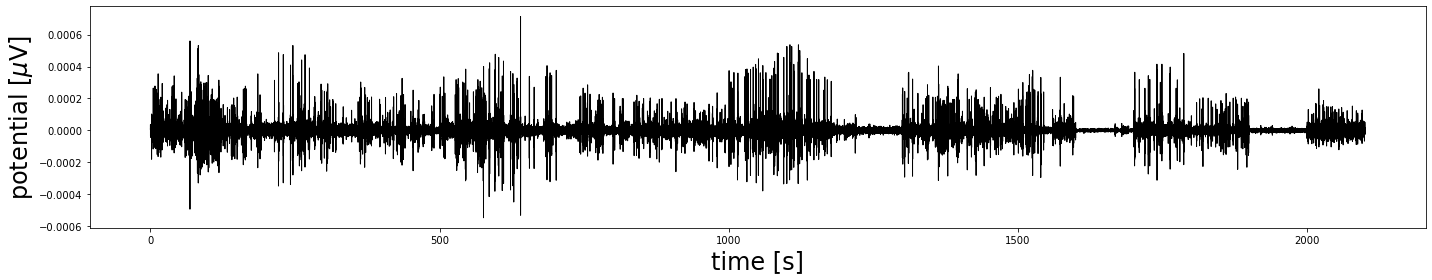

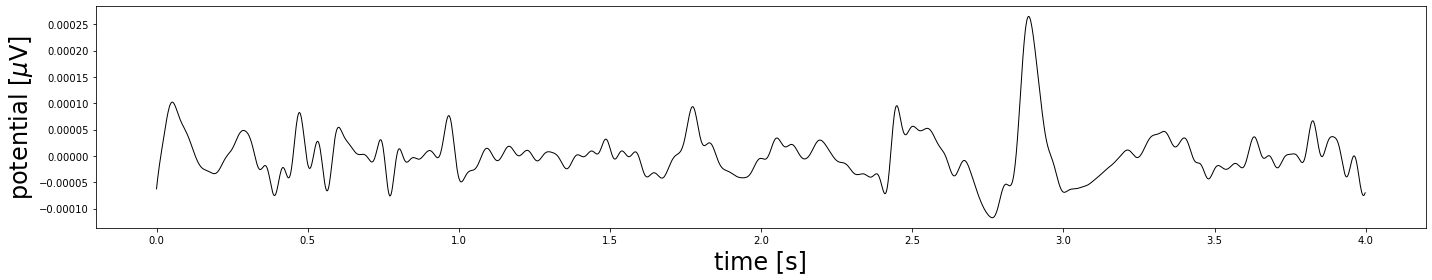

Clustering algorithm: kmeans
[+] Data format for clustering [GFP peaks, channels]: 38501 x 64

[+] Clustering algorithm: mod. K-MEANS.
	K-means run 1/5 converged after 33 iterations.
	K-means run 2/5 converged after 63 iterations.
	K-means run 3/5 converged after 68 iterations.
	K-means run 4/5 converged after 15 iterations.
	K-means run 5/5 converged after 16 iterations.
[+] Computation time: 8.13 sec

[+] Microstate back-fitting:
data_norm:  (1050105, 64)
data_cluster_norm:  (38501, 64)
maps:  (4, 64)

[+] Global explained variance GEV = 0.697
GEV_0: 0.061
GEV_1: 0.067
GEV_2: 0.522
GEV_3: 0.047

Empirical symbol distribution (RTT):

p_0 = 0.226
p_1 = 0.239
p_2 = 0.277
p_3 = 0.258

Empirical transition matrix:

|0.9000.0420.0240.034|
|0.0400.9060.0210.033|
|0.0190.0190.9410.021|
|0.0300.0300.0230.916|

GFP peaks per sec.: 18.33

Global explained variance (GEV) per map:
GEV(ms-0) = 0.06
GEV(ms-1) = 0.07
GEV(ms-2) = 0.52
GEV(ms-3) = 0.05

total GEV: 0.697

Empirical entropy H = 1.38 (ma

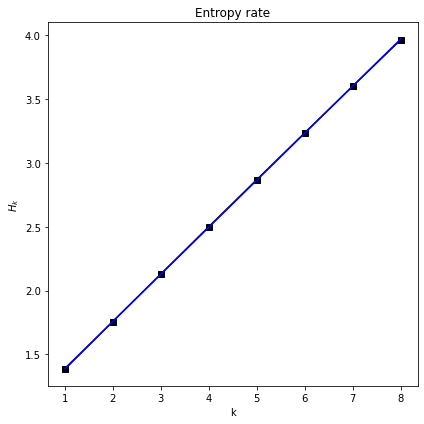


Empirical entropy rate h = 0.37
Theoretical MC entropy rate h = 0.37
The lzc:
(21,)
[2951, 3271, 3261, 3332, 3220, 3084, 3576, 3351, 3110, 3092, 3098, 3480, 3047, 3069, 3148, 3161, 3461, 3331, 3424, 3663, 2]


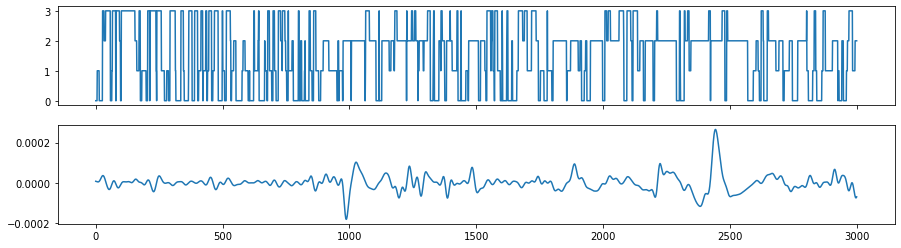

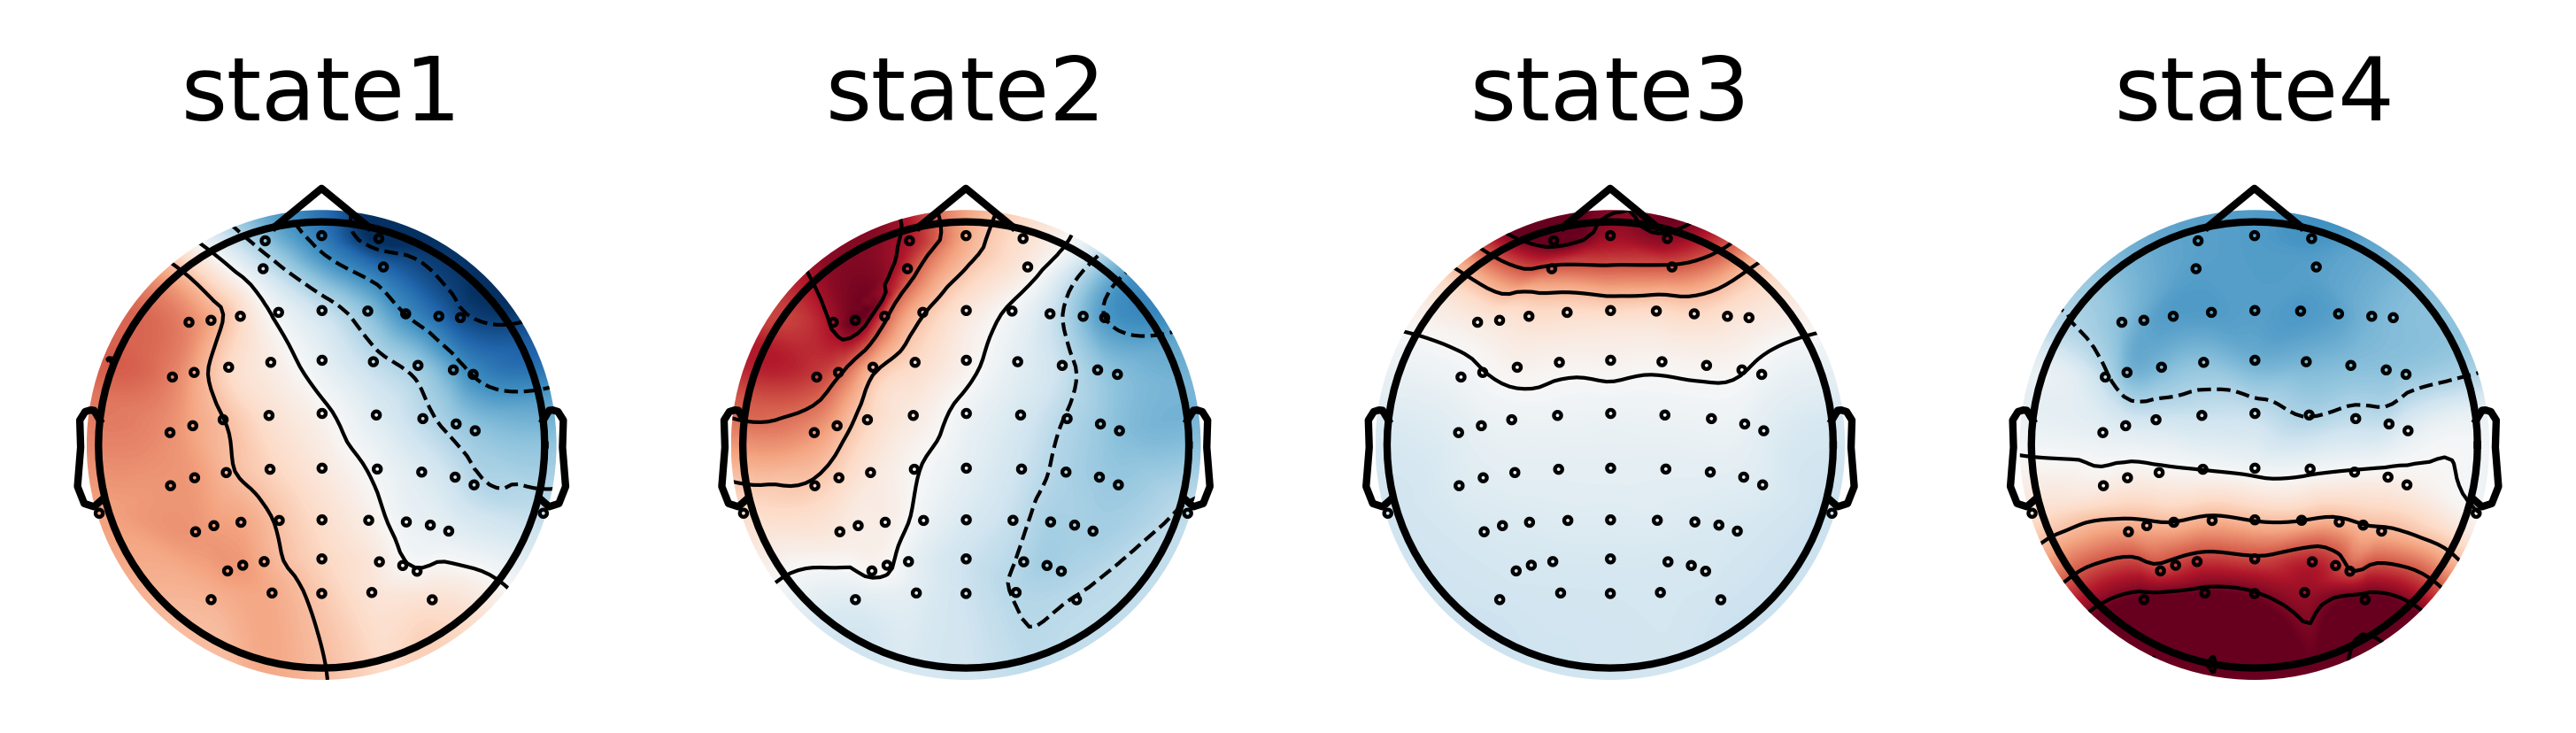

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

In [4]:
vars_4R = display_maps(epoch_4R, n_maps=4, save=True, dpi=600, filename='40Hz_rest',
fmt='.png', to_save_cache=to_save_cache, time_augs=time_augs, tm=tm, result_dir=result_dir,
calc_lzc=True, epochs=epochs_4R,save_log=True)

(37505, 64)


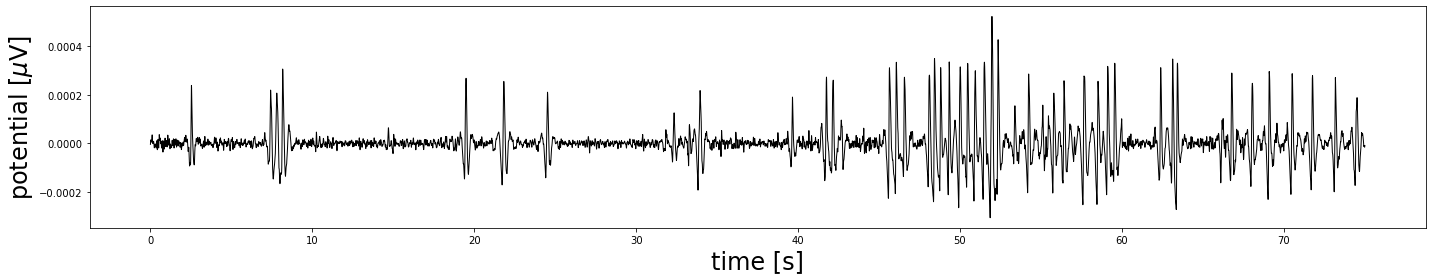

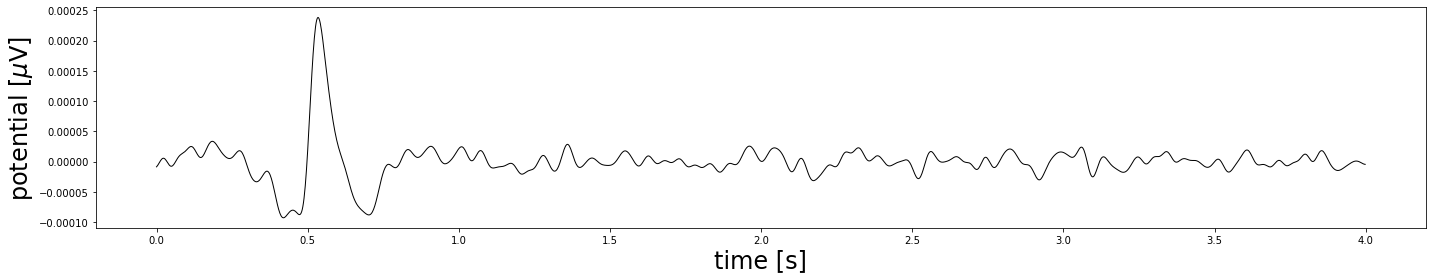

Clustering algorithm: kmeans
[+] Data format for clustering [GFP peaks, channels]: 1272 x 64

[+] Clustering algorithm: mod. K-MEANS.
	K-means run 1/5 converged after 18 iterations.
	K-means run 2/5 converged after 23 iterations.
	K-means run 3/5 converged after 20 iterations.
	K-means run 4/5 converged after 24 iterations.
	K-means run 5/5 converged after 11 iterations.
[+] Computation time: 0.59 sec

[+] Microstate back-fitting:
data_norm:  (37505, 64)
data_cluster_norm:  (1272, 64)
maps:  (4, 64)

[+] Global explained variance GEV = 0.846
GEV_0: 0.025
GEV_1: 0.020
GEV_2: 0.616
GEV_3: 0.185

Empirical symbol distribution (RTT):

p_0 = 0.348
p_1 = 0.082
p_2 = 0.292
p_3 = 0.278

Empirical transition matrix:

|0.9350.0160.0200.030|
|0.0700.8570.0350.037|
|0.0230.0110.9440.023|
|0.0370.0110.0240.928|

GFP peaks per sec.: 16.96

Global explained variance (GEV) per map:
GEV(ms-0) = 0.02
GEV(ms-1) = 0.02
GEV(ms-2) = 0.62
GEV(ms-3) = 0.18

total GEV: 0.846

Empirical entropy H = 1.29 (max. e

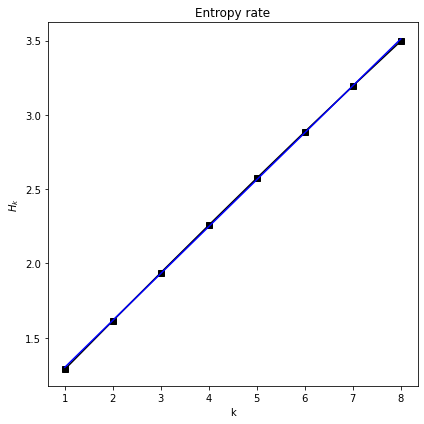


Empirical entropy rate h = 0.32
Theoretical MC entropy rate h = 0.33
The lzc:
(21,)
[216, 205, 189, 216, 197, 168, 197, 199, 195, 205, 205, 200, 175, 138, 176, 147, 192, 215, 164, 150, 2]


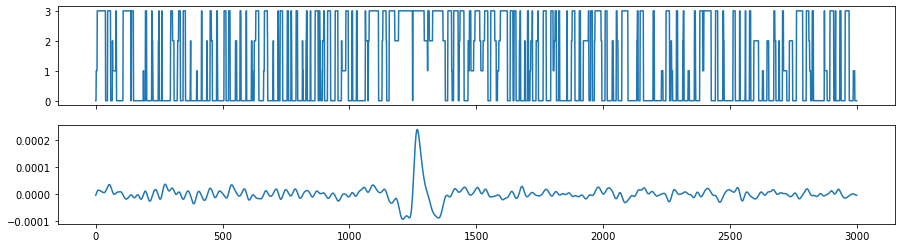

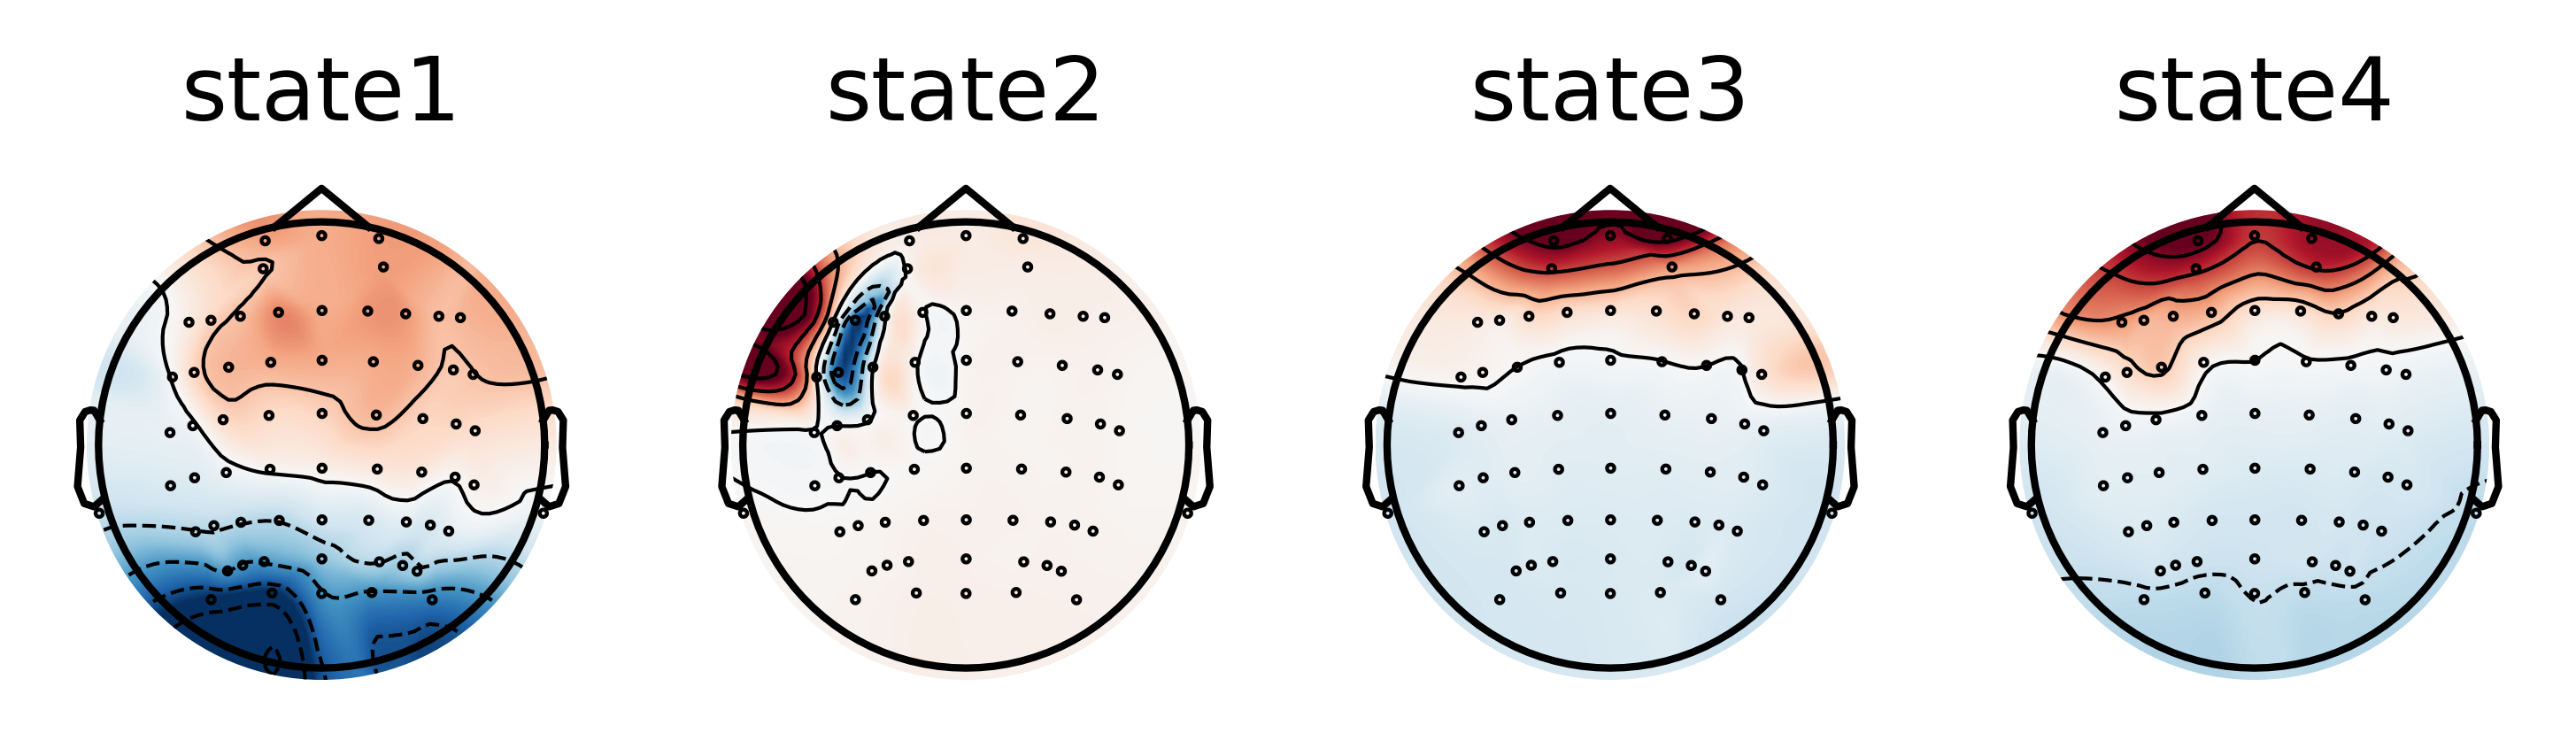

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

In [5]:
vars_4F = display_maps(epoch_4F, n_maps=4, save=True, dpi=600, filename='40Hz_flicker', 
fmt='.png', to_save_cache=to_save_cache, time_augs=time_augs, tm=tm, result_dir=result_dir,
calc_lzc=True, epochs=epochs_4F,save_log=True)

In [6]:
""" display_maps(epoch_RF, n_maps=4, save=True, dpi=400, filename='Random_flicker', 
fmt='.png', to_save_cache=to_save_cache, time_augs=time_augs, tm=tm, result_dir=result_dir,
calc_lzc=True, epochs=epochs_RF,save_log=False) """

" display_maps(epoch_RF, n_maps=4, save=True, dpi=400, filename='Random_flicker', \nfmt='.png', to_save_cache=to_save_cache, time_augs=time_augs, tm=tm, result_dir=result_dir,\ncalc_lzc=True, epochs=epochs_RF,save_log=False) "

In [24]:
gfp_4F = epoch_4F.get_data().reshape(37505,64)
gfp_4F = gfp_4F.std(axis=1)

In [12]:
gfp.shape

()

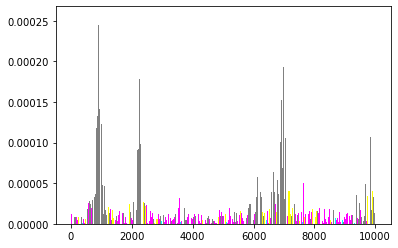

In [31]:
bar_color = []
for i in vars_4F[1]:
    if i == 0:
        bar_color.append('magenta')
    elif i == 1:
        bar_color.append('cyan')
    elif i == 2:
        bar_color.append('yellow')
    elif i == 3:
        bar_color.append('gray')
plt.bar(range(10000), abs(vars_4F[5][10000:20000]), color=bar_color[10000:20000]) # or `color=['r', 'g', 'b']`
plt.show()

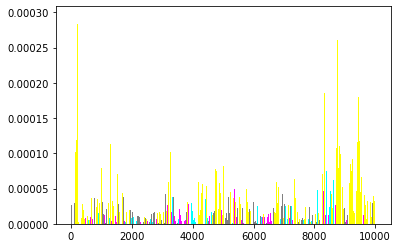

In [32]:
bar_color = []
for i in vars_4R[1]:
    if i == 0:
        bar_color.append('magenta')
    elif i == 1:
        bar_color.append('cyan')
    elif i == 2:
        bar_color.append('yellow')
    elif i == 3:
        bar_color.append('gray')
plt.bar(range(10000), abs(vars_4R[5][10000:20000]), color=bar_color[10000:20000]) # or `color=['r', 'g', 'b']`
plt.show()

In [44]:
dur_4F = []
prev_stat = vars_4F[1][0]
u = 0
for i,x in enumerate(vars_4F[1][1:]):
    if not x == prev_stat:
        dur_4F.append(i-u)
        u = i
avg_dur_4F = np.mean(dur_4F)
print("4F:", avg_dur_4F)

dur_4R = []
prev_stat = vars_4R[1][0]
u = 0
for i,x in enumerate(vars_4R[1][1:]):
    if not x == prev_stat:
        dur_4R.append(i-u)
        u = i
avg_dur_4R = np.mean(dur_4R)
print("4R:", avg_dur_4R)

4F: 1.5334260130024124
4R: 1.291800088325856


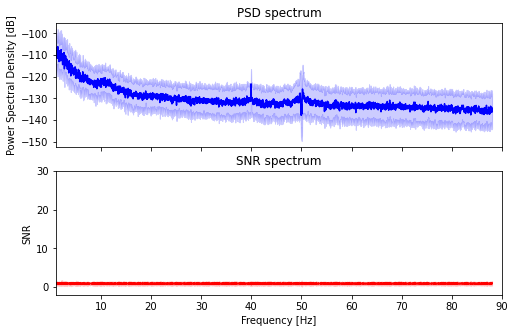

In [55]:
tmin = 0.
tmax = 160.
fmin = 1.
fmax = 90.
sfreq = epoch_4F.info['sfreq']
psds, freqs = mne.time_frequency.psd_welch(
    epoch_4F,
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=int(sfreq * (tmax - tmin)),
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=1)
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig.show()